In [ ]:
# default_exp protein_intensities

# Protein Intensity Estimation

Derive protein intensity profiles from quantitative peptide data by 1) normalizing out sample-specific biases 2) normalizing out peptide-specific ionization factors and 3) taking a median estimate.

In [ ]:
#export
from alphaquant.background_distributions import *
from alphaquant.normalization import *
from alphaquant.diff_analysis import *
from alphaquant.visualizations import *
from alphaquant.benchmarking import *
from alphaquant.diffquant_utils import *
from alphaquant.diff_analysis_manager import read_tables

## Wrapper function for normalizing proteins from external input file

In [ ]:
#export
import pandas as pd
import numpy as np
import alphaquant.normalization as aqnorm
def run_protein_normalization(input_file, protein_header, ion_header):
    input_df = pd.read_csv(input_file, sep = "\t")
    input_df = input_df.set_index([protein_header, ion_header])
    input_df = input_df.replace(0, np.nan)
    input_df = np.log2(input_df)
    sample2shift = aqnorm.get_normfacts_withincond(input_df.to_numpy().T)
    normed = aqnorm.apply_sampleshifts(input_df.to_numpy().T, sample2shift)
    betweencond_normed = pd.DataFrame(normed.T, index = input_df.index, columns= input_df.columns)
    protnormed_df, ionnormed_df = estimate_protein_intensities(betweencond_normed)
    protnormed_df.to_csv(f"{input_file}.proteins.out", sep = "\t")
    ionnormed_df.to_csv(f"{input_file}.ions.out", sep = "\t")


## Estimate protein intensity profiles
After normalizing out the sample-specific biases, the protein intensities are estimated. For each protein, the peptide intensity profiles (i.e. the intensity of the peptide in each sample), are extracted. These profiles are then shifted on top of each other by multiplying each peptide profile with a constant scaling factor. This normalizes out the peptide-specific biases, for example due to differing ionization efficiencies. After shifting, the median intensity is chosen as the represenatative protein intensity for each sample. The relative protein profile is the rescaled to the overall summed peptide intensity.

In [ ]:
#export
import alphaquant.normalization as aqnorm
def estimate_protein_intensities(normed_df):
    prot_ints = []
    ion_ints = []

    count_prots = 0
    idx = normed_df.index.get_level_values(0)
    idx_ions = normed_df.index.get_level_values(1)
    allprots = idx.unique()
    for protein in allprots:
        if(count_prots%100 ==0):
            print(f"prot {count_prots} of {len(allprots)}")
        count_prots+=1

        protvals_df = pd.DataFrame(normed_df.loc[protein])

        protvals = protvals_df.to_numpy().copy()
        summed_pepints = np.nansum(2**protvals)
        if(protvals.shape[1]<2):
            normed_protvals = protvals
        else:
            sample2shift = aqnorm.get_normfacts_withincond(protvals)
            normed_protvals = aqnorm.apply_sampleshifts(protvals, sample2shift)
        
        sample2reps = normed_protvals.T

        intens_vec = []
        for sample_idx in range(len(sample2reps)):
            reps = np.array(sample2reps[sample_idx])
            nonan_elems = sum(~np.isnan(reps))
            if(nonan_elems>=1):
                intens_vec.append(np.nanmedian(reps))
            else:
                intens_vec.append(np.nan)
        
        intens_vec = np.array(intens_vec)
        intens_conversion_factor = summed_pepints/np.nansum(2**intens_vec)
        scaled_vec = intens_vec+np.log2(intens_conversion_factor)
        prot_ints.append(scaled_vec)
        ion_ints.extend(normed_protvals)

    protein_df = 2**pd.DataFrame(prot_ints, index = allprots, columns = normed_df.columns)
    protein_df = protein_df.replace(np.nan, 0)
    ion_df = 2**pd.DataFrame(ion_ints, index = normed_df.index, columns = normed_df.columns)
    ion_df = ion_df.replace(np.nan, 0)
    return protein_df, ion_df

Visualize the peptide profiles for a given protein

In [ ]:
#export
import matplotlib.pyplot as plt
import numpy as np
def plot_lines(protvals, log = True):
    colors = plt.cm.tab20c(np.linspace(0,1,protvals.shape[0]))
    #cmap = plt.get_cmap("tab20c")
    idx = 0
    for row in protvals:
        if not log:
            row = 2**row
        plt.plot(row, c= colors[idx])
        idx+=1
    median_row = np.nanmedian(protvals, axis=0)
    print(median_row)
    plt.plot(median_row, c = 'black',linewidth =3 )
    plt.show()

def plot_points(protvals, log = True):
    colors = plt.cm.tab20c(np.linspace(0,1,protvals.shape[0]))
    #cmap = plt.get_cmap("tab20c")
    idx = 0
    for row in protvals:
        if not log:
            row = 2**row
        x_coord = list(range(len(row)))
        plt.scatter(x_coord,row, c= colors[idx])
        idx+=1

    plt.show()

Example data for single protein

,Intensity Shotgun_02-01_1,Intensity Shotgun_02-01_2,Intensity Shotgun_02-01_3,Intensity Shotgun_12-01_1,Intensity Shotgun_12-01_2,Intensity Shotgun_12-01_3
protein,,,,,,
3397,29.122265,29.011533,29.093820,28.722475,29.400324,29.416512
1686,26.163188,24.679761,24.979904,26.079414,24.579321,26.580616
3376,30.478330,30.828204,30.775399,30.736232,30.637040,30.683251
5693,27.286554,27.297541,26.855829,27.195052,27.250861,27.310049
6196,25.362396,25.812670,24.831343,25.537333,25.396294,25.143785
...,...,...,...,...,...,...
4611,NaN,NaN,24.273862,24.365660,23.873294,24.665558
4015,31.878338,32.034200,32.080385,31.646652,31.786734,31.863573
4015,23.692701,NaN,NaN,23.515913,22.350034,NaN


,Intensity Shotgun_02-01_1,Intensity Shotgun_02-01_2,Intensity Shotgun_02-01_3,Intensity Shotgun_12-01_1,Intensity Shotgun_12-01_2,Intensity Shotgun_12-01_3
protein,,,,,,
3397,29.122265,29.011533,29.093820,28.722475,29.400324,29.416512
3397,28.916032,28.473865,28.406904,28.223368,28.529970,27.247495
3397,28.541638,28.891455,29.273079,28.490753,28.835081,28.777883
3397,28.570309,28.889135,28.689270,28.812839,28.881423,28.240779
3397,26.488298,26.839661,27.064720,27.478612,27.024918,26.384103
3397,25.739571,NaN,25.883800,25.865275,26.275949,26.496080
3397,28.496560,28.628049,28.818565,28.803451,28.812812,28.876763


[28.54163823 28.75859215 28.68927004 28.49075331 28.81281231 28.24077901]


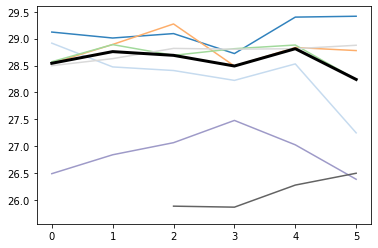

[29.0051717  29.22563834 29.2252827  29.04174612 29.34428983 29.24141678]


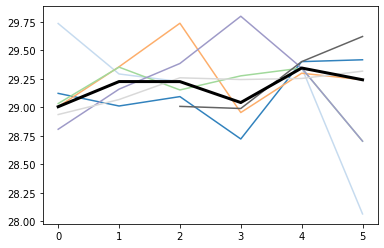

In [ ]:
#hide
import os 
import matplotlib.pyplot as plt
import numpy as np
import alphaquant.normalization as aqnorm


peptides_tsv = "./test_data/normed_mqquant_peps.tsv"
samplemap_tsv = "./test_data/samples.mq.ecoli.map"

unnormed_df, labelmap_df = read_tables(peptides_tsv, samplemap_tsv, pepheader="peptide")

unnormed_df = unnormed_df.set_index("protein")
display(unnormed_df)
protvals_df = unnormed_df.loc["3397"]
display(protvals_df)
protvals = protvals_df.to_numpy()
sample2shift = aqnorm.get_normfacts_withincond(protvals_df.copy().to_numpy())
normed_protvals = aqnorm.apply_sampleshifts(protvals, sample2shift)


plot_lines(protvals)
plot_lines(normed_protvals)

Alternative function for estimating the peptide normalization factors

In [ ]:
#hide
def norm_peptides_centroid_like(pep2reps):
    res = []
    l = list(pep2reps)
    l = list(filter(lambda pep : sum(~np.isnan(pep))>1, l))
    l.sort(key=lambda pep: np.nansum(pep), reverse= True)
    l.sort(key=lambda pep: sum(np.isnan(pep)))
    ref_pep = l[0]
    res.append(ref_pep)
    for idx in range(1, len(l)):
        to_shift_pep = l[idx]
        shifted = ref_pep - to_shift_pep
        num_nonans = sum(~np.isnan(shifted))
        if(num_nonans>1):
            shift_factor = np.nanmedian(shifted)
            shifted_pep = to_shift_pep+shift_factor
            res.append(shifted_pep)
    return np.array(res)



In [ ]:
# peptides_tsv = "./test_data/normed_mqquant_peps.tsv"
# samplemap_tsv = "./test_data/samples.mq.ecoli.map"
# normed_df, _ = read_tables(peptides_tsv, samplemap_tsv, "precursor")
# normed_df = normed_df.dropna(subset=["protein"])
# uniq_prots_1 = set(normed_df["protein"].unique())
# uniq_prots_2 = set(pd.read_csv("./test_data/proteinGroups.txt", sep = "\t", usecols = ["Protein IDs"])["Protein IDs"].unique())
# from matplotlib_venn import venn2
# venn2([uniq_prots_1, uniq_prots_2])
# weird_prots = uniq_prots_1 -uniq_prots_2
# print(weird_prots)

In [ ]:
#hide
#use MQ pep output

import numpy as np
import pandas as pd


prot 0 of 6946


/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/Users/constantin/workspace/EmpiRe/MS-EmpiRe_Python/ms_empire/normalization.py:98: RuntimeWarning: Degrees of freedom <= 0 for slice.
  res = np.nanvar(fcdist)


prot 100 of 6946
prot 200 of 6946
prot 300 of 6946
prot 400 of 6946
prot 500 of 6946
prot 600 of 6946
prot 700 of 6946
prot 800 of 6946
prot 900 of 6946
prot 1000 of 6946
prot 1100 of 6946
prot 1200 of 6946
prot 1300 of 6946
prot 1400 of 6946
prot 1500 of 6946
prot 1600 of 6946
prot 1700 of 6946
prot 1800 of 6946
prot 1900 of 6946
prot 2000 of 6946
prot 2100 of 6946
prot 2200 of 6946
prot 2300 of 6946
prot 2400 of 6946
prot 2500 of 6946
prot 2600 of 6946
prot 2700 of 6946
prot 2800 of 6946
prot 2900 of 6946
prot 3000 of 6946
prot 3100 of 6946
prot 3200 of 6946
prot 3300 of 6946
prot 3400 of 6946
prot 3500 of 6946
prot 3600 of 6946
prot 3700 of 6946
prot 3800 of 6946
prot 3900 of 6946
prot 4000 of 6946
prot 4100 of 6946
prot 4200 of 6946
prot 4300 of 6946
prot 4400 of 6946
prot 4500 of 6946
prot 4600 of 6946
prot 4700 of 6946
prot 4800 of 6946
prot 4900 of 6946
prot 5000 of 6946
prot 5100 of 6946
prot 5200 of 6946
prot 5300 of 6946
prot 5400 of 6946
prot 5500 of 6946
prot 5600 of 6946
p

In [ ]:
#hide


,peptide,Intensity Shotgun_02-01_1,Intensity Shotgun_02-01_2,Intensity Shotgun_02-01_3,Intensity Shotgun_12-01_1,Intensity Shotgun_12-01_2,Intensity Shotgun_12-01_3,protein
0,AAAAAAAAAPAAAATAPTTAATTAATAAQ,5.838620e+08,5.411800e+08,5.729445e+08,4.444887e+08,7.110721e+08,7.107059e+08,3397
1,AAAAAAAGDSDSWDADAFSVEDPVRK,7.508260e+07,2.687500e+07,3.309027e+07,7.115740e+07,2.515632e+07,9.954058e+07,1686
2,AAAAAAALQAK,1.494606e+09,1.906400e+09,1.837885e+09,1.794990e+09,1.675723e+09,1.710080e+09,3376
3,AAAAAAGAASGLPGPVAQGLK,1.635709e+08,1.649600e+08,1.214535e+08,1.541916e+08,1.602731e+08,1.650371e+08,5693
4,AAAAAAGSGTPR,4.309997e+07,5.893700e+07,2.985239e+07,4.886945e+07,4.431803e+07,3.676809e+07,6196
...,...,...,...,...,...,...,...,...
8471,DVYIVQDLMETDLYK,0.000000e+00,2.459900e+07,2.972414e+07,2.426805e+07,2.422557e+07,2.192416e+07,3183;853
8472,DVYLSPR,2.553057e+08,3.082800e+08,0.000000e+00,2.364004e+08,0.000000e+00,2.322613e+08,3438;5583
8473,DVYNHFLLYYGR,1.400103e+07,4.914200e+07,1.094425e+07,9.366006e+06,2.224746e+07,2.928572e+07,5022
8474,DVYTGDALR,2.210798e+08,3.792200e+08,0.000000e+00,1.873137e+07,2.917898e+08,0.000000e+00,2973


prot 0 of 3718


/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/Users/constantin/workspace/EmpiRe/MS-EmpiRe_Python/ms_empire/normalization.py:98: RuntimeWarning: Degrees of freedom <= 0 for slice.
  res = np.nanvar(fcdist)


prot 100 of 3718
prot 200 of 3718
prot 300 of 3718
prot 400 of 3718
prot 500 of 3718
prot 600 of 3718
prot 700 of 3718
prot 800 of 3718
prot 900 of 3718
prot 1000 of 3718
prot 1100 of 3718
prot 1200 of 3718
prot 1300 of 3718
prot 1400 of 3718
prot 1500 of 3718
prot 1600 of 3718
prot 1700 of 3718
prot 1800 of 3718
prot 1900 of 3718
prot 2000 of 3718
prot 2100 of 3718
prot 2200 of 3718
prot 2300 of 3718
prot 2400 of 3718
prot 2500 of 3718
prot 2600 of 3718
prot 2700 of 3718
prot 2800 of 3718
prot 2900 of 3718
prot 3000 of 3718
prot 3100 of 3718
prot 3200 of 3718
prot 3300 of 3718
prot 3400 of 3718
prot 3500 of 3718
prot 3600 of 3718
prot 3700 of 3718


,Intensity Shotgun_02-01_1,Intensity Shotgun_02-01_2,Intensity Shotgun_02-01_3,Intensity Shotgun_12-01_1,Intensity Shotgun_12-01_2,Intensity Shotgun_12-01_3
protein,,,,,,
3397,1.148453e+09,9.489836e+08,9.540375e+08,7.899175e+08,1.111108e+09,7.080507e+08
1686,4.354128e+08,2.988373e+08,3.680807e+08,3.328870e+08,2.638258e+08,2.893228e+08
3376,1.900799e+09,1.664190e+09,1.673312e+09,2.230403e+09,1.623649e+09,1.966302e+09
5693,3.096169e+08,3.220687e+08,3.338525e+08,3.235596e+08,3.588370e+08,3.345739e+08
6196,6.030553e+07,7.339640e+07,4.668853e+07,6.638225e+07,7.238430e+07,6.930765e+07
...,...,...,...,...,...,...
6636,1.287029e+08,8.979900e+07,1.005544e+08,9.572979e+07,1.097118e+08,8.808806e+07
6698,2.385225e+08,1.403800e+08,1.330879e+08,1.816461e+08,2.211769e+08,2.338439e+08
5414,3.606041e+07,4.836200e+07,5.388048e+07,4.964899e+07,5.315739e+07,4.399586e+07


pandas.core.frame.DataFrame

In [ ]:
def plot_on_identical_proteins(fcnorm_df):
    subset_df = fcnorm_df[['HeLa2_median_ref', 'HeLa12_median_ref', 'HeLa2_median', 'HeLa12_median']].replace([np.inf, -np.inf, 0], np.nan)
    subset_df = subset_df.dropna()
    display(subset_df.describe())
    intersect_idx = subset_df.index
    
    intersec_df = fcnorm_df.loc[intersect_idx]
    plot_fold_change(intersec_df, 'HeLa2_median_ref', 'HeLa12_median_ref')
    plot_fold_change(intersec_df, 'HeLa2_median', 'HeLa12_median')
    

prot 0 of 6946


/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/Users/constantin/workspace/EmpiRe/MS-EmpiRe_Python/ms_empire/normalization.py:98: RuntimeWarning: Degrees of freedom <= 0 for slice.
  res = np.nanvar(fcdist)


prot 100 of 6946
prot 200 of 6946
prot 300 of 6946
prot 400 of 6946
prot 500 of 6946
prot 600 of 6946
prot 700 of 6946
prot 800 of 6946
prot 900 of 6946
prot 1000 of 6946
prot 1100 of 6946
prot 1200 of 6946
prot 1300 of 6946
prot 1400 of 6946
prot 1500 of 6946
prot 1600 of 6946
prot 1700 of 6946
prot 1800 of 6946
prot 1900 of 6946
prot 2000 of 6946
prot 2100 of 6946
prot 2200 of 6946
prot 2300 of 6946
prot 2400 of 6946
prot 2500 of 6946
prot 2600 of 6946
prot 2700 of 6946
prot 2800 of 6946
prot 2900 of 6946
prot 3000 of 6946
prot 3100 of 6946
prot 3200 of 6946
prot 3300 of 6946
prot 3400 of 6946
prot 3500 of 6946
prot 3600 of 6946
prot 3700 of 6946
prot 3800 of 6946
prot 3900 of 6946
prot 4000 of 6946
prot 4100 of 6946
prot 4200 of 6946
prot 4300 of 6946
prot 4400 of 6946
prot 4500 of 6946
prot 4600 of 6946
prot 4700 of 6946
prot 4800 of 6946
prot 4900 of 6946
prot 5000 of 6946
prot 5100 of 6946
prot 5200 of 6946
prot 5300 of 6946
prot 5400 of 6946
prot 5500 of 6946
prot 5600 of 6946
p

pandas.core.frame.DataFrame

,HeLa2_median_ref,HeLa12_median_ref,HeLa2_median,HeLa12_median
count,5.884000e+03,5.884000e+03,5.884000e+03,5.884000e+03
mean,1.782796e+09,1.702419e+09,1.382626e+09,1.029534e+09
std,5.707220e+09,5.630880e+09,4.525952e+09,3.270452e+09
min,4.623200e+06,3.340900e+06,2.862000e+06,1.468694e+06
25%,9.206350e+07,8.020900e+07,6.794284e+07,4.881565e+07
50%,3.084350e+08,2.759800e+08,2.324123e+08,1.741948e+08
75%,1.195525e+09,1.097775e+09,9.184635e+08,6.824666e+08
max,1.138300e+11,1.066300e+11,1.113890e+11,7.051104e+10


Species=Human, n=4966, median=-0.28350409084318096, dev=0.3308752134395907
species=Ecoli, n=888, median=2.275011072896654, dev=0.8552492440696641


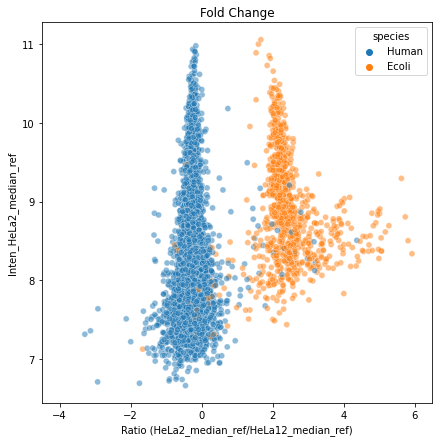

Species=Human, n=4966, median=0.039170770373242764, dev=0.345589083098399
species=Ecoli, n=888, median=2.5670516493371824, dev=0.5898143471507593


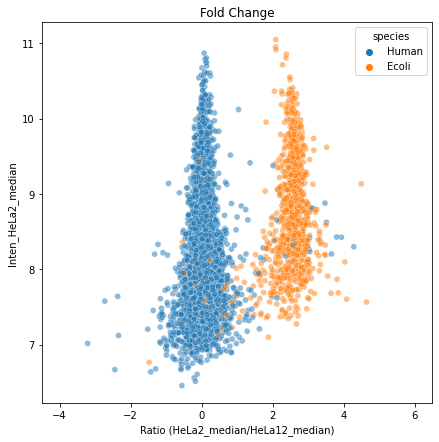

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Species=Human, n=4848, median=-0.27384239825201767, dev=0.452237593455074
species=Ecoli, n=888, median=2.285774668404909, dev=0.9553427727410664


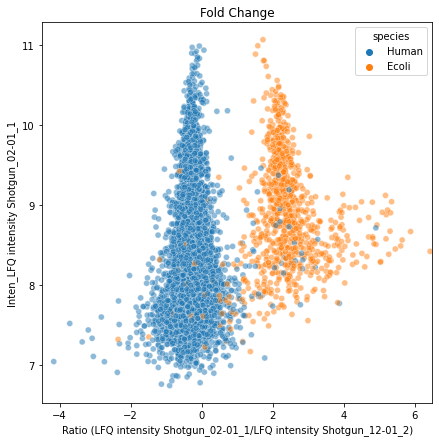

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Species=Human, n=4820, median=0.039798810032546976, dev=0.4937198157596814
species=Ecoli, n=879, median=2.55993233613421, dev=0.700129129780571


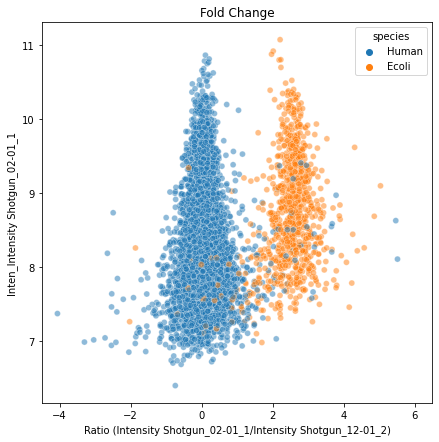

,Intensity Shotgun_02-01_1,Intensity Shotgun_02-01_2,Intensity Shotgun_02-01_3,Intensity Shotgun_12-01_1,Intensity Shotgun_12-01_2,Intensity Shotgun_12-01_3,HeLa2_median,HeLa12_median,LFQ intensity Shotgun_02-01_1,LFQ intensity Shotgun_02-01_2,LFQ intensity Shotgun_02-01_3,LFQ intensity Shotgun_12-01_1,LFQ intensity Shotgun_12-01_2,LFQ intensity Shotgun_12-01_3,species,protein,HeLa12_median_ref,HeLa2_median_ref
3397,2.198773e+09,2.561813e+09,2.561182e+09,2.255228e+09,2.781411e+09,2.589985e+09,2.561182e+09,2.589985e+09,2439800000,2663100000,2709300000,3422300000,3790600000,3589200000,Human,3397,3.589200e+09,2.663100e+09
1686,4.473430e+09,4.619048e+09,4.200032e+09,4.912461e+09,4.463984e+09,3.952910e+09,4.473430e+09,4.463984e+09,4383000000,5713300000,5323200000,5979700000,6701500000,6184300000,Human,1686,6.184300e+09,5.323200e+09
3376,1.758897e+10,1.508888e+10,1.456102e+10,1.437269e+10,1.339866e+10,1.385823e+10,1.508888e+10,1.385823e+10,19829000000,16819000000,15898000000,20145000000,17964000000,18437000000,Human,3376,1.843700e+10,1.681900e+10
5693,1.529300e+09,1.518583e+09,1.311087e+09,1.564308e+09,1.588834e+09,1.517938e+09,1.518583e+09,1.564308e+09,1771000000,1701200000,1649100000,2156700000,2159100000,2197700000,Human,5693,2.159100e+09,1.701200e+09
6196,6.035113e+07,7.339017e+07,4.668457e+07,6.614253e+07,7.212291e+07,6.987259e+07,6.035113e+07,6.987259e+07,69286000,83470000,52996000,94452000,103660000,99112000,Human,6196,9.911200e+07,6.928600e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,8.091450e+08,9.109600e+08,9.126112e+08,1.080623e+09,8.267097e+08,1.078991e+09,9.109600e+08,1.078991e+09,611450000,780690000,747290000,1177900000,876960000,1084400000,Human,129,1.084400e+09,7.472900e+08
2608,3.154313e+07,2.526700e+07,3.278796e+07,0.000000e+00,3.165449e+06,0.000000e+00,3.154313e+07,0.000000e+00,36318000,28820000,37329000,0,4563000,0,Ecoli,2608,0.000000e+00,3.631800e+07
3003,2.063879e+07,5.138600e+07,3.440944e+07,0.000000e+00,4.416559e+06,0.000000e+00,3.440944e+07,0.000000e+00,245420000,332240000,336000000,0,6364700,0,Ecoli,3003,0.000000e+00,3.322400e+08
479,0.000000e+00,0.000000e+00,4.768362e+07,3.918230e+07,3.776803e+07,4.231790e+07,0.000000e+00,3.918230e+07,0,0,54287000,56115000,54443000,60201000,Human,479,5.611500e+07,0.000000e+00


,Intensity Shotgun_02-01_1,Intensity Shotgun_02-01_2,Intensity Shotgun_02-01_3,Intensity Shotgun_12-01_1,Intensity Shotgun_12-01_2,Intensity Shotgun_12-01_3,HeLa2_median,HeLa12_median
protein,,,,,,,,
3397,2.198773e+09,2.561813e+09,2.561182e+09,2.255228e+09,2.781411e+09,2.589985e+09,2.561182e+09,2.589985e+09
1686,4.473430e+09,4.619048e+09,4.200032e+09,4.912461e+09,4.463984e+09,3.952910e+09,4.473430e+09,4.463984e+09
3376,1.758897e+10,1.508888e+10,1.456102e+10,1.437269e+10,1.339866e+10,1.385823e+10,1.508888e+10,1.385823e+10
5693,1.529300e+09,1.518583e+09,1.311087e+09,1.564308e+09,1.588834e+09,1.517938e+09,1.518583e+09,1.564308e+09
6196,6.035113e+07,7.339017e+07,4.668457e+07,6.614253e+07,7.212291e+07,6.987259e+07,6.035113e+07,6.987259e+07
...,...,...,...,...,...,...,...,...
1594;4424,5.106326e+07,4.195100e+07,4.458519e+07,4.377876e+07,4.416097e+07,0.000000e+00,4.458519e+07,4.377876e+07
3003,2.063879e+07,5.138600e+07,3.440944e+07,0.000000e+00,4.416559e+06,0.000000e+00,3.440944e+07,0.000000e+00
479,0.000000e+00,0.000000e+00,4.768362e+07,3.918230e+07,3.776803e+07,4.231790e+07,0.000000e+00,3.918230e+07


In [ ]:
import pandas as pd

import numpy as np
import pandas as pd


peptides_mq = "./test_data/normed_mqquant_peps.tsv"
samplemap_mq = "./test_data/samples.mq.ecoli.map"
normed_df, _ = read_tables(peptides_tsv, samplemap_tsv, "peptide")
normed_df = normed_df.dropna(subset=["protein"])
normed_df = normed_df.reset_index()
normed_df = normed_df.set_index(["protein", "ion"])
protein_df,_ = estimate_protein_intensities(normed_df)


mq_lfq = pd.read_csv("./test_data/proteinGroups.txt", sep = "\t", usecols = ["LFQ intensity Shotgun_12-01_1", "LFQ intensity Shotgun_12-01_2", "LFQ intensity Shotgun_12-01_3",
"LFQ intensity Shotgun_02-01_1", "LFQ intensity Shotgun_02-01_2", "LFQ intensity Shotgun_02-01_3", "Species", "id"]).rename(columns = {"Species":"species",
"id" : "protein"})
mq_lfq["species"] = mq_lfq["species"].replace(to_replace={"Homo sapiens" : "Human", "Escherichia coli" : "Ecoli"})
mq_lfq = mq_lfq.astype({"protein" :"str"})
minrep = 2

ap_c1_filt_idx = mq_lfq[["LFQ intensity Shotgun_12-01_1", "LFQ intensity Shotgun_12-01_2", "LFQ intensity Shotgun_12-01_3"]].dropna(thresh=minrep, axis=0).index
ap_c2_filt_idx = mq_lfq[["LFQ intensity Shotgun_02-01_1", "LFQ intensity Shotgun_02-01_2", "LFQ intensity Shotgun_02-01_3"]].dropna(thresh=minrep, axis=0).index

mq_lfq["HeLa12_median_ref"] = mq_lfq[["LFQ intensity Shotgun_12-01_1", "LFQ intensity Shotgun_12-01_2", "LFQ intensity Shotgun_12-01_3"]].median(axis = 1)
mq_lfq["HeLa2_median_ref"] = mq_lfq[["LFQ intensity Shotgun_02-01_1", "LFQ intensity Shotgun_02-01_2", "LFQ intensity Shotgun_02-01_3"]].median(axis = 1)
idx_intersect = ap_c1_filt_idx.intersection(ap_c2_filt_idx)
mq_lfq = mq_lfq.loc[idx_intersect]

display(type(protein_df))
protein_df["HeLa2_median"] = protein_df[["Intensity Shotgun_02-01_1", "Intensity Shotgun_02-01_2", "Intensity Shotgun_02-01_3"]].median(axis = 1)
protein_df["HeLa12_median"] = protein_df[["Intensity Shotgun_12-01_1", "Intensity Shotgun_12-01_2", "Intensity Shotgun_12-01_3"]].median(axis = 1)

fcnorm_annot = protein_df.merge(mq_lfq, left_index= True, right_on= "protein", suffixes= (None, "_ref"))

plot_on_identical_proteins(fcnorm_annot)



plot_fold_change(fcnorm_annot, "LFQ intensity Shotgun_02-01_1", "LFQ intensity Shotgun_12-01_2")
plot_fold_change(fcnorm_annot, 'Intensity Shotgun_02-01_1', "Intensity Shotgun_12-01_2")
display(fcnorm_annot)
display(protein_df)



,protein,PXD006109_HeLa12_1_LFQ,PXD006109_HeLa12_2_LFQ,PXD006109_HeLa12_3_LFQ,PXD006109_HeLa2_1_LFQ,PXD006109_HeLa2_2_LFQ,PXD006109_HeLa2_3_LFQ,PXD006109_HeLa12_1,PXD006109_HeLa12_2,PXD006109_HeLa12_3,...,HeLa12_1,precursor,HeLa12_2,HeLa12_3,HeLa2_1,HeLa2_2,HeLa2_3,species,HeLa12_median_ref,HeLa2_median_ref
0,sp|P36578|RL4_HUMAN,5.535647e+10,4.496180e+10,4.786562e+10,4.307915e+10,3.523617e+10,3.580661e+10,5.892905e+10,4.526883e+10,4.276544e+10,...,971513414.0,KPLVGK_2,893871809.0,985189279.0,691297616.0,851138496.0,541841950.0,Human,4.786562e+10,3.580661e+10
1,sp|Q9P258|RCC2_HUMAN,5.040674e+09,4.318525e+09,4.973918e+09,4.307535e+09,3.415510e+09,3.562226e+09,5.971181e+09,4.734482e+09,4.153145e+09,...,457596530.0,SSTAAQEVK_2,381209191.0,256570404.0,NaN,NaN,324676280.0,Human,4.973918e+09,3.562226e+09
2,sp|P55036|PSMD4_HUMAN,3.663486e+09,3.473264e+09,2.910355e+09,3.339283e+09,2.702214e+09,2.550902e+09,3.953403e+09,3.918737e+09,3.128546e+09,...,306766162.0,LHTVQPK_2,332229397.0,308139245.0,160286706.0,300162867.0,161454022.0,Human,3.473264e+09,2.702214e+09
3,sp|Q9NQP4|PFD4_HUMAN,1.507582e+09,1.177011e+09,1.225331e+09,NaN,8.589166e+08,1.071547e+09,1.304392e+09,9.851766e+08,1.528412e+09,...,750467804.0,NLQEEIDALESR_2,504447053.0,611693431.0,NaN,339422930.0,432822111.0,Human,1.225331e+09,9.652318e+08
4,sp|Q01780|EXOSX_HUMAN,2.844178e+09,3.095957e+09,2.919838e+09,2.080623e+09,1.806327e+09,1.880328e+09,2.657281e+09,1.592799e+09,1.849392e+09,...,175289062.0,IYEISNR_2,NaN,NaN,NaN,NaN,NaN,Human,2.919838e+09,1.880328e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5981,sp|Q9Y287|ITM2B_HUMAN,NaN,NaN,1.586439e+08,NaN,5.936193e+08,NaN,NaN,NaN,1.586427e+08,...,NaN,VTFNSALAQK_2,NaN,158642696.0,NaN,593620520.0,NaN,Human,1.586439e+08,5.936193e+08
5982,sp|Q8FL63|DDLB_ECOL6,NaN,NaN,2.191570e+07,2.036206e+08,2.007224e+08,9.282310e+07,NaN,NaN,2.126620e+07,...,NaN,VVAENALQDALR_2,NaN,21266202.0,197616189.0,194750214.0,90068828.0,Ecoli,2.191570e+07,2.007224e+08
5988,sp|Q9UHW5|GPN3_HUMAN,NaN,NaN,2.245543e+08,NaN,NaN,1.709889e+08,NaN,NaN,2.086303e+08,...,NaN,YAQLVMGPAGSGK_2,NaN,208630261.0,NaN,NaN,158756561.0,Human,2.245543e+08,1.709889e+08
5990,sp|Q14315|FLNC_HUMAN,NaN,NaN,5.258933e+08,NaN,3.280941e+08,4.628415e+08,NaN,NaN,5.037978e+08,...,NaN,YGGDEIPYSPFR_2,NaN,503797750.0,NaN,314322281.0,443318130.0,Human,5.258933e+08,3.954678e+08


Species=Human, n=4344, median=-0.4110078006012575, dev=0.6448116512435641
species=Ecoli, n=626, median=2.393957930933362, dev=0.7672329444126358


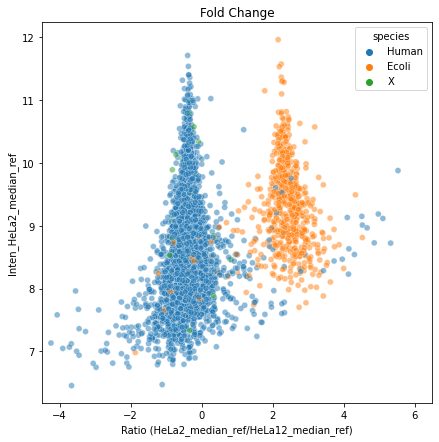

Species=Human, n=0, median=nan, dev=nan
species=Ecoli, n=0, median=nan, dev=nan


/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


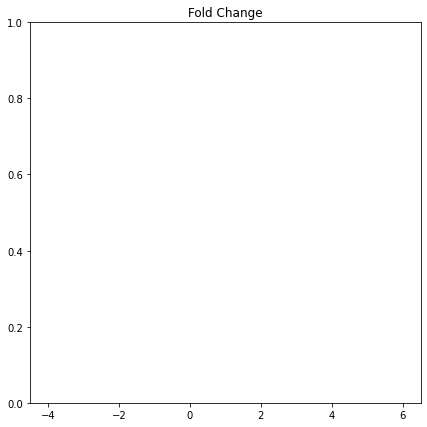

Species=Human, n=3338, median=-0.3771170512513031, dev=0.4844298494980092
species=Ecoli, n=450, median=2.426809065264167, dev=0.5764341810089724


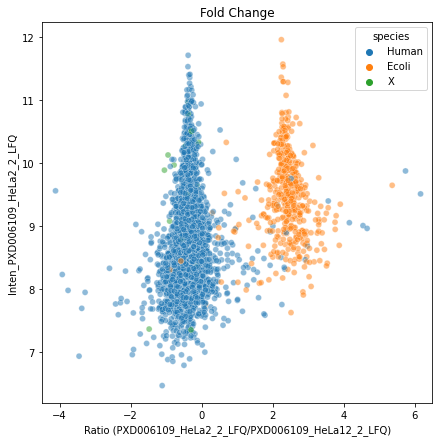

Species=Human, n=0, median=nan, dev=nan
species=Ecoli, n=0, median=nan, dev=nan


/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


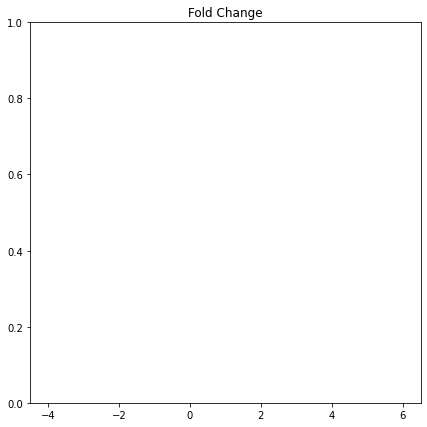

In [ ]:
import pandas as pd

# ap_lfq = pd.read_csv("./test_data/results_proteins.csv")
# ap_annot = pd.read_csv("./test_data/ap_quant_peptides.tsv", sep = "\t").drop_duplicates(subset = 'protein')
# ap_lfq = ap_lfq.merge(ap_annot, on = "protein")

ap_lfq = pd.read_csv("./test_data/results_proteins.csv")
ap_annot = pd.read_csv("./test_data/ap_quant_peptides.tsv", sep = "\t").drop_duplicates(subset = 'protein')
ap_lfq = ap_lfq.merge(ap_annot, on = "protein")
minrep = 1
ap_c1_filt_idx = ap_lfq[["PXD006109_HeLa12_1_LFQ", "PXD006109_HeLa12_2_LFQ", "PXD006109_HeLa12_3_LFQ"]].dropna(thresh=minrep, axis=0).index
ap_c2_filt_idx = ap_lfq[["PXD006109_HeLa2_1_LFQ", "PXD006109_HeLa2_2_LFQ", "PXD006109_HeLa2_3_LFQ"]].dropna(thresh=minrep, axis=0).index

ap_lfq["HeLa12_median_ref"] = ap_lfq[["PXD006109_HeLa12_1_LFQ", "PXD006109_HeLa12_2_LFQ", "PXD006109_HeLa12_3_LFQ"]].median(axis = 1)
ap_lfq["HeLa2_median_ref"] = ap_lfq[["PXD006109_HeLa2_1_LFQ", "PXD006109_HeLa2_2_LFQ", "PXD006109_HeLa2_3_LFQ"]].median(axis = 1)
idx_intersect = ap_c1_filt_idx.intersection(ap_c2_filt_idx)
ap_lfq = ap_lfq.loc[idx_intersect]
display(ap_lfq)



fcnorm_annot = protein_df.merge(ap_annot, left_index= True, right_on= "protein", suffixes= (None, "_ref"))
fcnorm_annot["HeLa12_median"] = fcnorm_annot[["HeLa12_1","HeLa12_2","HeLa12_3"]].median(axis = 1)
fcnorm_annot["HeLa2_median"] = fcnorm_annot[["HeLa2_1","HeLa2_2","HeLa2_3"]].median(axis = 1)


plot_fold_change(ap_lfq, 'HeLa2_median_ref', 'HeLa12_median_ref')
plot_fold_change(fcnorm_annot, 'HeLa2_median', 'HeLa12_median')

plot_fold_change(ap_lfq, 'PXD006109_HeLa2_2_LFQ', 'PXD006109_HeLa12_2_LFQ')
plot_fold_change(fcnorm_annot, 'HeLa2_2', 'HeLa12_2')

#display(protein_df)
